# Simulate BESS
This is a code to simulate the use of Batteries to reduce the electricity price of an industry/consumer
- We are using PyPSA as the optimizer package and
- We simplify the generation by using the marginal price of electricity documented by SMARD: https://www.smard.de/home/downloadcenter/download-marktdaten/
- The technology data can be found in here: https://github.com/PyPSA/technology-data
- We are just using default data, but with the insights of real batteries, we can potentially have a clearer results for optimization
- The load demand is arbitary, for now we set a constant value by default

## Data preparation

In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

In [2]:
def extract_market_price(years):

    results = pd.DataFrame()
    for year in years:
        market_price = pd.read_csv(
            f"SMARD_market_price_{year}.csv",
            sep=';',
            decimal=',',           # If numbers use comma as decimal point
            parse_dates=True,      # If there are date columns
            dayfirst=True          # If dates are in DD.MM.YYYY format
        )
        market_price["Datum von"] = pd.to_datetime(market_price["Datum von"], format="%d.%m.%Y %H:%M")
        market_price["Datum bis"] = pd.to_datetime(market_price["Datum bis"], format="%d.%m.%Y %H:%M")
        
        de_price = market_price[["Datum von","Deutschland/Luxemburg [€/MWh] Originalauflösungen"]]
        de_price.columns = ["DE Electricity Market",f"market_price_{year}"]
        de_price = de_price.set_index("DE Electricity Market")
        
        # Drop leap days (Feb 29)
        de_price = de_price[~((de_price.index.month == 2) & (de_price.index.day == 29))]

        # ✅ Reset the year to 2025 for all timestamps
        de_price.index = de_price.index.map(lambda dt: dt.replace(year=2025))

        # remove duplicate index
        de_price = de_price.groupby(de_price.index).mean()

        results = pd.concat([results,de_price], axis = 1)

    # Fill nan values
    results = results.interpolate(method="linear")
    
    return results

years = [2019, 2020, 2021, 2022, 2023, 2024]

market_price = extract_market_price(years)
market_price_25 = extract_market_price([2025])

market_price = pd.concat([market_price,market_price_25], axis=1)

market_price.to_csv("market_price.csv")

## Running the simple optimization

In [5]:
def optimize_simple_model(market_price_series, add_battery=True, **kwarg):
    """
    Sets up and optimizes a simple energy system model using PyPSA.

    The model includes:
    - A single electricity bus (e.g., representing Germany),
    - A generator with time-varying marginal costs from the given market price series,
    - A fixed industrial load,
    - Optionally, a battery energy storage system (BESS) with user-defined parameters.

    The function runs a linear optimal power flow (LOPF) optimization to minimize 
    total system cost over the given time period.

    read more on components here: https://pypsa.readthedocs.io/en/latest/user-guide/components.html

    Parameters:
    -----------
        market_price_series (pandas.Series): Time-indexed series of electricity market prices (€/MWh).
        add_battery (bool, optional): Whether to include a battery storage unit in the model (default: True).
        **kwarg: Dictionary containing model parameters:
            - 'Load': Dict with 'p_set' (fixed demand in MW).
            - 'StorageUnit': Dict with 'p_nom', 'max_hours', and 'marginal_cost' 
                             for battery config (only used if add_battery is True).

    Returns:
    --------
        state_of_charge (pandas.Series): Battery state of charge over time (if battery is included).
        system_cost (float): Total system cost in million euros per year.
    """

    # Create a new empty network
    n = pypsa.Network()
    
    n.set_snapshots(market_price_series.index)
    
    # Add a single bus (e.g. "DE")
    n.add("Bus", "DE")
    
    # Add a generator connected to that bus
    n.add("Generator",
          "DE Electricity Market",
          bus="DE",
          p_nom_extendable=True,
          marginal_cost=market_price_series         # €/MWh
    )
    
    # Add a load connected to the same bus
    n.add("Load",
          "Industry",
          bus="DE",
          p_set=kwarg["Load"]["p_set"]              # Fixed demand (MW)
    )

    if add_battery:
        # Add a battery
        n.add("StorageUnit",
              "BESS",
              bus="DE",
              p_nom=kwarg["StorageUnit"]["p_nom"],  # Fixed capacity (MW)
              max_hours=kwarg["StorageUnit"]["max_hours"], 
              marginal_cost=kwarg["StorageUnit"]["marginal_cost"],
             )
    
    # Optional: run linear optimal power flow (LOPF)
    n.optimize()
    
    # View results
    state_of_charge = n.storage_units_t.state_of_charge["BESS"]

    # Power rate of batteries (MW)
    battery_power = n.storage_units_t.p["BESS"]
    
    # Revenue time series (€/h) from discharging
    battery_revenue = battery_power * market_price_series

    return state_of_charge, battery_revenue

def simulate_myopic_optimization(market_price, years, date, **kwarg):
    """
    Simulates a myopic (short-term) energy system optimization for different years 
    using a simple model. The optimization uses historical or current market prices 
    up to "day-ahead" and switches to future market prices for each target year 
    beyond that point.

    This is useful for comparing how the system would behave in the near future 
    under different historical market price patterns.

    Parameters:
    -----------
        market_price (pandas.DataFrame): A DataFrame with datetime index and one column per year, 
                                         named like "market_price_<year>".
        years (list of int): List of years to simulate using future market prices.
        date (str or pd.Timestamp): The starting date of the simulation (e.g., '2025-07-01').
        **kwarg:

    Returns:
    --------
        state_of_charge (pandas.DataFrame): Battery state of charge throughout the year
        system_cost (dict): Dictionary mapping each year to its corresponding system cost (in million €/a).
    """

    current_date = pd.to_datetime(date)
    day_ahead = current_date + pd.Timedelta(days=1)
    week_ahead = current_date + pd.Timedelta(days=7)

    state_of_charge = pd.DataFrame()
    battery_revenue = pd.DataFrame()
    
    for year in years:
        # Extract relevant slices
        recent_prices = market_price.loc[market_price.index <= day_ahead, f"market_price_{current_date.year}"]
        future_prices = market_price.loc[market_price.index > day_ahead, f"market_price_{year}"]
        
        # Combine them into one consistent Series
        market_price_series = pd.concat([recent_prices, future_prices]).sort_index()
        
        state_of_charge_year, battery_revenue_year = optimize_simple_model(market_price_series, **kwarg)

        state_of_charge = pd.concat([state_of_charge, state_of_charge_year], axis=1)
        battery_revenue = pd.concat([battery_revenue, battery_revenue_year], axis=1)

    return state_of_charge, battery_revenue


def plot_soc_forecast(df, date, name, unit="MWh"):
    """
    Plots the forecasted state of charge (SoC) distribution over a 7-day window, 
    starting from a given date, using quantile shading to represent uncertainty 
    across multiple simulation scenarios.

    The plot includes:
    - Shaded quantile ranges (0–100%, 25–75%, 37.5–62.5%) for SoC across scenarios,
    - A median SoC line,
    - A vertical marker for the day-ahead market boundary,
    - Labels, grid, and a saved PNG file of the plot.

    Parameters:
        df (pandas.DataFrame): DataFrame where each column represents 
                                             a simulation scenario, and the index is a datetime.
        date (str or pd.Timestamp): The starting date for the 7-day forecast window 
                                    (e.g., '2025-07-01').
        unit : str, optional (default = "€")
            The unit of measurement, displayed on the y-axis label.

    Returns:
        None. (Displays and saves the plot as 'state_of_charge_plot.png'.)
    """

    current_date = pd.to_datetime(date)
    day_ahead = current_date + pd.Timedelta(days=1)
    week_ahead = current_date + pd.Timedelta(days=7)

    # Cut the time series only for the next week
    df = df[current_date:week_ahead]

    # Calculate percentiles across columns for each timestamp
    q_0 = df.min(axis=1)  # or .quantile(0.0)
    q_25 = df.quantile(0.25, axis=1)
    q_37 = df.quantile(0.375, axis=1)
    q_50 = df.median(axis=1)
    q_62 = df.quantile(0.625, axis=1)
    q_75 = df.quantile(0.75, axis=1)
    q_100 = df.max(axis=1)  # or .quantile(1.0)

    # Start plotting
    plt.figure(figsize=(14, 6))

    # Lightest area: min to max (0–100%)
    plt.fill_between(df.index, q_0, q_100, color='black', alpha=0.2, label='0–100% range')

    # Medium area: 25–75%
    plt.fill_between(df.index, q_25, q_75, color='black', alpha=0.4, label='25–75% range')

    # Darkest area: 37.5–62.5%
    plt.fill_between(df.index, q_37, q_62, color='black', alpha=0.6, label='37.5–62.5% range')

    # median line
    plt.plot(df.index, q_50, color='blue', linestyle='-', linewidth=2, label='Median SoC')

    # Day-ahead market
    
    plt.axvline(day_ahead, color='red', linestyle='--', linewidth=2)
    plt.text(
        x=day_ahead,
        y=q_100.max(),
        s="day-ahead market",
        color='red',
        rotation=90,
        verticalalignment='top',
        horizontalalignment='right'
    )

    # Formatting
    plt.title(f"{name} Quantile Ranges")
    plt.xlabel("Time")
    plt.xlim(df.index.min(), df.index.max())
    plt.ylabel(f"{name} ({unit})")
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name}_plot.png", dpi=300)  # Save to file
    plt.show()

def plot_revenue_forecast(df, date, name, unit="€"):
    """
    Plots weekly revenue forecast vs. realized revenue for a battery system.

    This function takes a time series DataFrame of battery revenue simulations 
    (e.g., from multiple year scenarios), slices the data to 1 month before and 
    after a specified `date`, aggregates it weekly, and plots the 25–75% quantile 
    range as forecast bars. It also includes realized revenue data for the historical period.

    Parameters:
    -----------
    df : pd.DataFrame
        A DataFrame with datetime index and revenue simulations as columns.
    
    date : str or pd.Timestamp
        The reference date (typically the current date). The plot will show 
        one month before and after this date.
    
    name : str
        The name of the metric being plotted (e.g., "Battery Revenue").
        This is used in the plot title and y-axis label.
    
    unit : str, optional (default = "€")
        The unit of measurement, displayed on the y-axis label.

    Output:
    -------
    - A bar plot showing:
        * Historical realized revenue (approx. 25% quantile) in orange
        * Forecast revenue range (25–75% quantile) in green/light green
    - X-axis labeled by ISO week number (1–52)
    - Plot saved as "Battery Revenue_plot.png"
    """
    
    # Convert and define date ranges
    current_date = pd.to_datetime(date)
    month_ahead = current_date + pd.DateOffset(months=1)
    month_behind = current_date - pd.DateOffset(months=1)
    
    # Slice the DataFrame for 1 month before and after
    df = df[month_behind:month_ahead]
    
    # Ensure datetime index
    df.index = pd.to_datetime(df.index)
    
    # Resample weekly
    df_weekly = df.resample("W").sum()
    
    # Compute quantiles across columns for each week
    q_25 = df_weekly.quantile(0.25, axis=1)
    q_75 = df_weekly.quantile(0.75, axis=1)
    iqr = q_75 - q_25
    
    # Split into historical and forecast periods
    historical_mask = (q_25.index >= month_behind) & (q_25.index < current_date)
    forecast_mask = (q_25.index >= current_date) & (q_25.index <= month_ahead)
    
    # Extract week numbers from datetime index
    week_numbers = q_25.index.isocalendar().week
    
    # Plot
    plt.figure(figsize=(14, 6))
    
    # Forecast bars (Max Revenue - stacked on Min)
    plt.bar(
        week_numbers[forecast_mask],
        iqr[forecast_mask],
        bottom=q_25[forecast_mask],
        width=0.8,
        color='lightgreen',
        alpha=1.0,
        label='Forecast Revenue (75% Quantile)'
    )
    
    # Forecast bars (Min Revenue)
    plt.bar(
        week_numbers[forecast_mask],
        q_25[forecast_mask],
        bottom=0,
        width=0.8,
        color='green',
        alpha=1.0,
        label='Forecast Revenue (25% Quantile)'
    )
    
    # Historical bars
    plt.bar(
        week_numbers[historical_mask],
        q_25[historical_mask],
        bottom=0,
        width=0.8,
        color='orange',
        alpha=1.0,
        label='Realized Revenue'
    )
    
    # Formatting
    plt.title(f"Weekly {name}: Realized vs Forecast (25–75% Range)")
    plt.xlabel("Week Number")
    plt.ylabel(f"{name} ({unit})")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.xticks(week_numbers, week_numbers)  # Set week numbers as tick labels
    plt.tight_layout()
    plt.savefig(f"Battery Revenue_plot.png", dpi=300)  # Save to file
    plt.show()

Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 106.40it/s]
INFO:linopy.io: Writing time: 0.31s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-fnjaukie has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11707     2.9363323700e+07 Pr: 0(0); Du: 0(4.44089e-16) 0s
Solving the original LP from the solution after postsolve


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 2.94e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Model name          : linopy-problem-fnjaukie
Model status        : Optimal
Simplex   iterations: 11707
Objective value     :  2.9363323700e+07
Relative P-D gap    :  2.4105076249e-15
HiGHS run time      :          0.20
Writing the solution to /tmp/linopy-solve-y_5ej4wv.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.62it/s]
INFO:linopy.io: Writing time: 0.29s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-qadari7i has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11663     2.9826377000e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-qadari7i
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 2.98e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Relative P-D gap    :  7.4939513407e-16
HiGHS run time      :          0.18
Writing the solution to /tmp/linopy-solve-b3v_ouso.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.17it/s]
INFO:linopy.io: Writing time: 0.32s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-f2qrmadn has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11712     4.7524309900e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-f2qrmadn
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 4.75e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Writing the solution to /tmp/linopy-solve-vanmmbsv.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 117.37it/s]
INFO:linopy.io: Writing time: 0.31s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-5qdt4c5b has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17447 rows, 34967 cols, 61100 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11667     3.6236163750e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-5qdt4c5b
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.62e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 124.49it/s]
INFO:linopy.io: Writing time: 0.28s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-vy3tw042 has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17447 rows, 34967 cols, 61100 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11667     3.6236163750e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-vy3tw042
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.62e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Writing the solution to /tmp/linopy-solve-tong4pw8.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.68it/s]
INFO:linopy.io: Writing time: 0.3s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-a__5_0kl has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 9e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17441 rows, 34961 cols, 61082 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11670     3.7621072300e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-a__5_0kl
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.76e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Relative P-D gap    :  5.9412824846e-16
HiGHS run time      :          0.18
Writing the solution to /tmp/linopy-solve-q7dtlb4y.sol


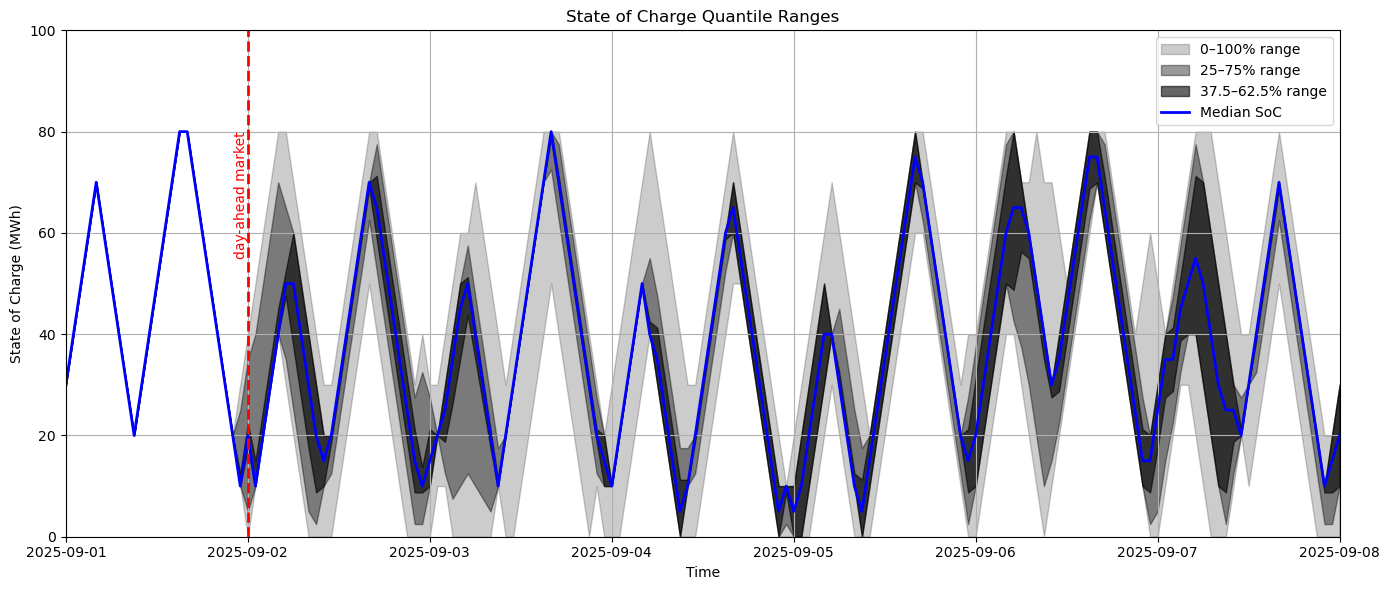

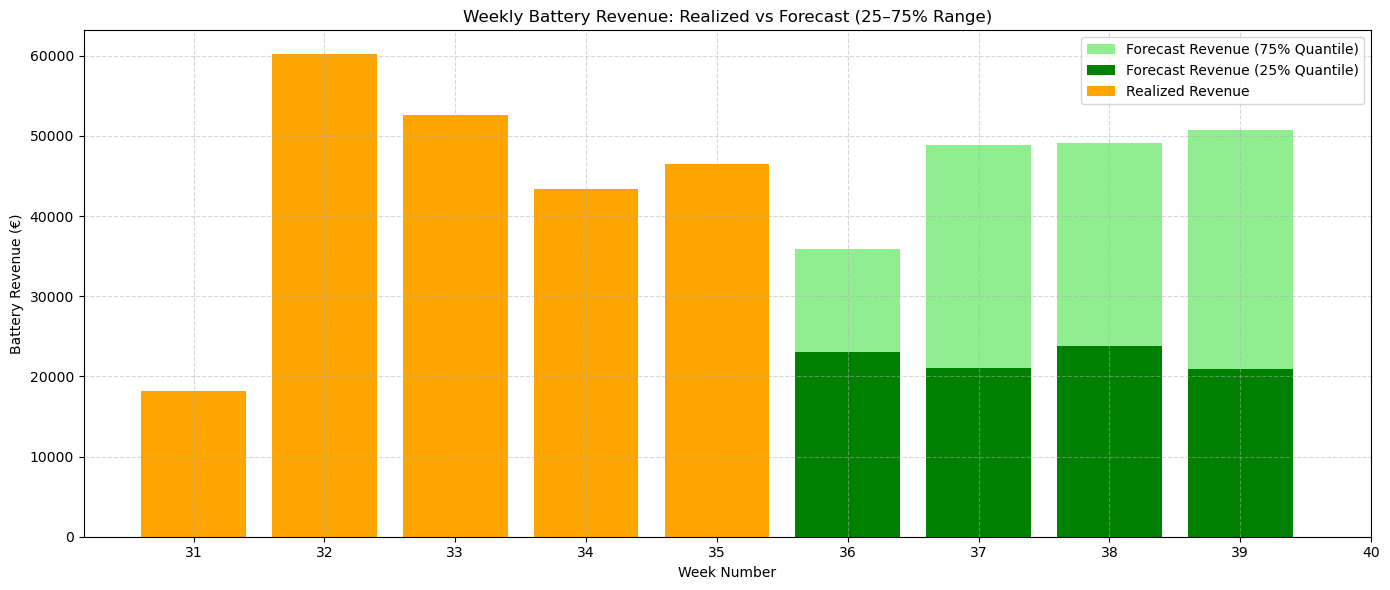

In [6]:
# You can set whatever capacity you want
kwarg = {
    "Load":{
        "p_set":50 # in MW
    },
    "StorageUnit":{
        "p_nom":10, # in MW (better less than load)
        "max_hours":8, # in hours
        "marginal_cost":0.1 # in €/MW
    },
}

# run this on the main repo level to work
market_price = pd.read_csv("market_price.csv", parse_dates=True, index_col=0)
years = [2019, 2020, 2021, 2022, 2023, 2024]

# We want to connect this date selection to the frontend. The maximul limit for this date is 2025-09-05
date = "2025-09-01"

state_of_charge, battery_revenue = simulate_myopic_optimization(
    market_price, 
    years, 
    date, 
    **kwarg
)


state_of_charge.to_csv("state_of_charge.csv")
battery_revenue.to_csv("battery_renevue.csv")

plot_soc_forecast(state_of_charge, date, "State of Charge", "MWh")
plot_revenue_forecast(battery_revenue, date, "Battery Revenue", "€")
